In [ ]:
!pip install captcha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 3.2 MB/s eta 0:00:00


In [ ]:
# 生成验证码图片
import os
import random
from captcha.image import ImageCaptcha
from google.colab import drive

# 创建目标文件夹（如果不存在）
save_dir = '/content/drive/MyDrive/CRNN_Captcha_DS/dataset/train'
os.makedirs(save_dir, exist_ok=True)  # exist_ok=True 防止文件夹已存在时报错

def generate_captcha(text, output_path):
    image = ImageCaptcha(width=160, height=60)
    data = image.generate(text)
    image.write(text, os.path.join(output_path, f"{text}.png"))  # 使用 os.path.join 确保路径兼容性

# 生成示例：生成1000个k字符数字验证码
chars = '0123456789abcdefghijklmnopqrstuvwxyz'
for _ in range(1000):
    text = ''.join(random.choices(chars, k=5))
    generate_captcha(text, save_dir)  # 使用定义好的保存路径

print(f"验证码已保存到：{save_dir}")


验证码已保存到：/content/drive/MyDrive/CRNN_Captcha_DS/dataset/train


Loaded checkpoint: Epoch 40, Best Acc 98.67%


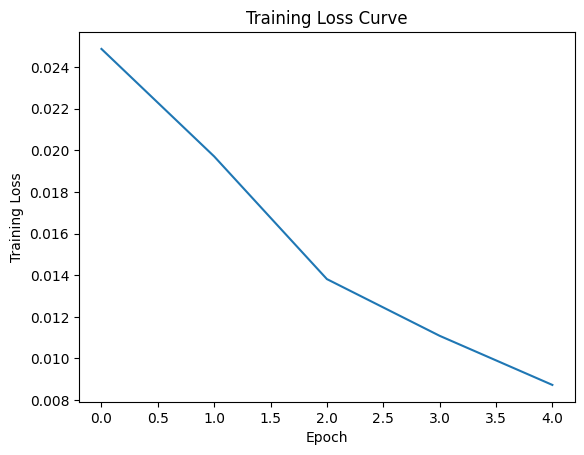

Epoch 045 | Loss: 0.0087 | Test Acc: 99.00%


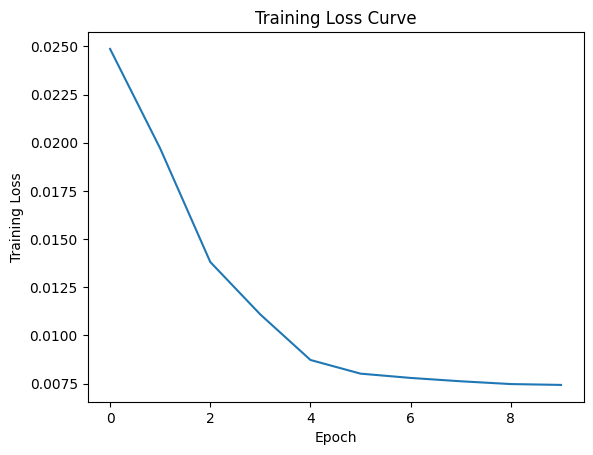

Epoch 050 | Loss: 0.0074 | Test Acc: 98.67%


Final Test Accuracy: 98.67%


'\n主要功能说明：\n检查点保存：\n\n自动保存完整训练状态到crnn_checkpoint.pth\n单独保存最佳模型到crnn_best_model.pth\n保存内容包括：\n模型参数\n优化器状态\n学习率调度器状态\n当前epoch\n最佳准确率\n恢复训练：\n\nbash\n复制代码\n# 默认加载crnn_checkpoint.pth\npython train.py\n\n# 指定检查点路径\npython train.py --resume path/to/checkpoint.pth\n使用最佳模型预测：\n\npython\n复制代码\n# 创建predict.py并添加以下代码\nprint(predict("your_image.png"))  # 输出预测结果\n注意事项：\n修改数据集路径/path/to/train和/path/to/test\n确保有至少10GB的磁盘空间存储检查点\n推荐使用GPU环境运行\n预测时需要保持CHAR_SET与训练时一致\n此代码实现了完整的训练恢复功能和模型部署能力，可以通过检查点灵活控制训练过程。\n\n'

In [ ]:
#带完整保存checkpoint版
#记得补充avg 梯度检查功能 以及如何跳出局部最小值（loss 3.7）
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import os
import cv2
import numpy as np
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt

# 超参数
BATCH_SIZE = 128
NUM_WORKERS = 4
IMG_SIZE = (160, 60)
CHAR_SET = '0123456789abcdefghijklmnopqrstuvwxyz'
BLANK_IDX = len(CHAR_SET)

# 数据预处理
"""
  图像处理 preprocess
    使用OpenCV读取灰度图像，缩放到固定尺寸（160x60）。
    归一化到[-1, 1]范围（公式：(img/255 - 0.5)/0.5）。
    转换为PyTorch张量，添加通道维度（1通道）。
"""
def preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = (img / 255.0 - 0.5) / 0.5
    return torch.FloatTensor(img).unsqueeze(0)

"""
  数据集类 CaptchaDataset
    遍历目录下所有.png文件。
    从文件名提取标签（如文件名abcd.png对应标签"abcd"）。
    将标签字符转换为预定义字符集CHAR_SET的索引（如字符'a'映射为索引10）
"""
class CaptchaDataset(Dataset):
    def __init__(self, root_dir):
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = preprocess(self.files[idx])
        label_str = os.path.splitext(os.path.basename(self.files[idx]))[0]
        label = [CHAR_SET.index(c) for c in label_str]
        return img, torch.LongTensor(label), len(label)
def collate_fn(batch):
    #处理变长标签，支持不同长度的验证码"""
    images = torch.stack([item[0] for item in batch])
    labels = [item[1].tolist() for item in batch]  # 标签转为列表（支持变长）
    label_lens = [item[2] for item in batch]
    return images, labels, label_lens

def custom_collate_fn(batch):
    images, labels, label_lens = zip(*batch)
    images = torch.stack(images, dim=0)  # 图像堆叠成 tensor
    labels = [torch.LongTensor(label) for label in labels]  # 标签保持为列表
    label_lens = torch.LongTensor(label_lens)  # 标签长度堆叠成 tensor
    return images, labels, label_lens

class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),#第一个2表示2*2的池化窗口，第二个2表示池化步长
            #变

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), (2,1), (0,1)),
        )
        """
        RNN部分（序列建模）
        双向LSTM：
          输入特征维度：256*7 = 1792（将CNN输出的高度和通道展平）。
          双向LSTM（2层，隐藏单元256，dropout 0.4），输出维度512（双向拼接）。
        全连接层：
          将LSTM输出映射到字符类别（37类：36字符 + 1空白符）。
        """
        self.rnn = nn.LSTM(
            input_size=256*7,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            dropout=0.4
        )
        self.fc = nn.Linear(512, len(CHAR_SET)+1)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.view(B, C*H, W).permute(2, 0, 1)
        x, _ = self.rnn(x)
        return self.fc(x)
"""
CTC损失：
  计算模型输出的对数概率与标签序列的损失，自动对齐不定长序列。
  输入长度：时间步数（固定为40），目标长度：标签实际字符数。
CTC解码：
  对模型输出的概率矩阵取每步最大类别，去除重复和空白符，得到最终字符串。
  例：模型输出[a, -, a, b] → 解码为"ab"

"""
def ctc_decode(preds):
    argmax = preds.argmax(-1)
    decoded = []
    for batch in argmax.T:
        chars = []
        last_idx = -1
        for idx in batch:
            idx = idx.item()
            if idx != BLANK_IDX and idx != last_idx:
                chars.append(CHAR_SET[idx])
            last_idx = idx
        decoded.append(''.join(chars))
    return decoded

def train(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for images, labels, label_lens in pbar:
        images = images.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            log_probs = torch.log_softmax(outputs, dim=2)

            # 修改后的标签处理逻辑
            labels_flat = torch.cat([torch.LongTensor(lbl) for lbl in labels]).to(device)
            input_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(device)
            target_lengths = torch.LongTensor(label_lens).to(device)

            loss = nn.CTCLoss(blank=BLANK_IDX)(
                log_probs, labels_flat, input_lengths, target_lengths
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, label_lens in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            outputs = model(images)
            pred_strs = ctc_decode(outputs)

            # 修改后的真实标签生成逻辑
            true_strs = [''.join([CHAR_SET[i] for i in lbl]) for lbl in labels]

            for pred, true in zip(pred_strs, true_strs):
                total_correct += (pred == true)
                total_samples += 1

    return total_correct / total_samples if total_samples !=0 else 0


def main():
     # 修正后的参数解析
    parser = argparse.ArgumentParser()
    parser.add_argument('--resume', type=str, default="/content/drive/MyDrive/CRNN_Captcha_DS/crnn_checkpoint.pth",
                    help="Path to checkpoint for resuming training")

    # 使用parse_known_args忽略Jupyter的额外参数
    args, _ = parser.parse_known_args()


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 初始化组件
    model = CRNN().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    scaler = GradScaler()

    # 加载检查点
    start_epoch = 1
    best_acc = 0
    if os.path.exists(args.resume):
        checkpoint = torch.load(args.resume, map_location=device)
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint: Epoch {checkpoint['epoch']}, Best Acc {best_acc:.2%}")

    # 数据加载
    train_set = CaptchaDataset('/content/drive/MyDrive/CRNN_Captcha_DS/dataset/train')
    test_set = CaptchaDataset('/content/drive/MyDrive/CRNN_Captcha_DS/dataset/test')

    train_loader = DataLoader(
      train_set,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=NUM_WORKERS,
      pin_memory=True,
      collate_fn=collate_fn  # 添加 collate_fn
    )

    test_loader = DataLoader(
      test_set,
      batch_size=BATCH_SIZE*2,
      num_workers=NUM_WORKERS,
      pin_memory=True,
      collate_fn=collate_fn  # 添加 collate_fn
    )

    losses = []  # 初始化损失列表
    # 训练循环
    for epoch in range(start_epoch, 51):
        train_loss = train(model, train_loader, optimizer, scaler, device)
        losses.append(train_loss)  # 记录每个epoch的损失

        scheduler.step(train_loss)

        if epoch % 5 == 0:
            #绘图
            plt.plot(losses)
            plt.xlabel('Epoch')
            plt.ylabel('Training Loss')
            plt.title('Training Loss Curve')
            plt.show()

            test_acc = evaluate(model, test_loader, device)
            print(f"Epoch {epoch:03d} | Loss: {train_loss:.4f} | Test Acc: {test_acc:.2%}")

            # 保存检查点
            if test_acc > best_acc:
                best_acc = test_acc
                checkpoint = {
                    'epoch': epoch,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'scheduler_state': scheduler.state_dict(),
                    'best_acc': best_acc
                }
                torch.save(checkpoint, args.resume)
                torch.save(model.state_dict(), os.path.join(os.path.dirname(args.resume), "crnn_best_model.pth"))
    final_acc = evaluate(model, test_loader, device)
    print(f"Final Test Accuracy: {final_acc:.2%}")

if __name__ == "__main__":
    torch.backends.cudnn.benchmark = True
    main()
"""
  原始图像 (160x60)
→ 预处理 → (1,160,60)
→ CNN → (256,20,15)
→ 序列化 → (15, B, 5120)
→ RNN → (15, B, 512)
→ 全连接 → (15, B, 37)
→ CTC解码 → 文本
"""



# 预测示例（可另存为predict.py）
"""
def predict(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CRNN().to(device)
    model.load_state_dict(torch.load("crnn_best_model.pth", map_location=device))
    model.eval()

    img = preprocess(image_path).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
    return ctc_decode(outputs)[0]
"""
"""
主要功能说明：
检查点保存：

自动保存完整训练状态到crnn_checkpoint.pth
单独保存最佳模型到crnn_best_model.pth
保存内容包括：
模型参数
优化器状态
学习率调度器状态
当前epoch
最佳准确率
恢复训练：


# 指定检查点路径
python train.py --resume path/to/checkpoint.pth
使用最佳模型预测：


"""

In [ ]:

def predict(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CRNN().to(device)
    model.load_state_dict(torch.load("/content/drive/MyDrive/CRNN_Captcha_DS/crnn_best_model.pth", map_location=device))
    model.eval()

    img = preprocess(image_path).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
    return ctc_decode(outputs)[0]
print(predict("/content/drive/MyDrive/CRNN_Captcha_DS/dataset/predict/gig4i.png"))

gig4i


In [ ]:
print("Labels:", labels[:5])
print("Label lengths:", label_lens[:5])

Labels: tensor([12, 26, 18, 15,  9], device='cuda:0')
Label lengths: tensor([4, 4, 4, 4, 4], device='cuda:0')


In [ ]:
#第一次实现准确率100%的模型 但未保存完整的checkpoint
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler  # 更新自动混合精度导入
import os
import cv2
import numpy as np
from tqdm import tqdm

# 超参数
BATCH_SIZE = 64  # 减小批量大小
NUM_WORKERS = 4
IMG_SIZE = (160, 60)
CHAR_SET = '0123456789abcdefghijklmnopqrstuvwxyz'
BLANK_IDX = len(CHAR_SET)  # 空白符索引

# 数据预处理（保持不变）
def preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = (img / 255.0 - 0.5) / 0.5
    return torch.FloatTensor(img).unsqueeze(0)

class CaptchaDataset(Dataset):
    def __init__(self, root_dir):
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = preprocess(self.files[idx])
        label_str = os.path.splitext(os.path.basename(self.files[idx]))[0]
        label = [CHAR_SET.index(c) for c in label_str]
        return img, torch.LongTensor(label), len(label)

# 改进的模型结构
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 增强CNN特征提取
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [64, 30, 80]

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [128, 15, 40]

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), (2,1), (0,1)),  # [256, 7, 41]
        )

        # 调整RNN参数
        self.rnn = nn.LSTM(
            input_size=256*7,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            dropout=0.3
        )
        self.fc = nn.Linear(512, len(CHAR_SET)+1)
        # 初始化全连接层
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.view(B, C*H, W).permute(2, 0, 1)  # [W, B, C*H]
        x, _ = self.rnn(x)  # [W, B, 512]
        return self.fc(x)  # [W, B, 37]

# CTC解码（保持不变）
def ctc_decode(preds):
    argmax = preds.argmax(-1)
    decoded = []
    for batch in argmax.T:
        chars = []
        last_idx = -1
        for idx in batch:
            idx = idx.item()
            if idx != BLANK_IDX and idx != last_idx:
                chars.append(CHAR_SET[idx])
            last_idx = idx
        decoded.append(''.join(chars))
    return decoded

# 训练函数修正
def train(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for images, labels, label_lens in pbar:
        images = images.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):  # 更新自动混合精度
            outputs = model(images)
            log_probs = torch.log_softmax(outputs, dim=2)
            input_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(device)
            labels_flat = labels.view(-1).to(device)
            target_lengths = torch.tensor(label_lens, dtype=torch.long).to(device)

            # 修正：设置blank参数
            loss = nn.CTCLoss(blank=BLANK_IDX)(
                log_probs, labels_flat, input_lengths, target_lengths
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(loader)

# 评估函数（保持不变）
def evaluate(model, loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, label_lens in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            outputs = model(images)
            pred_strs = ctc_decode(outputs)

            true_strs = []
            for label, length in zip(labels, label_lens):
                true_strs.append(''.join([CHAR_SET[i] for i in label[:length]]))

            for pred, true in zip(pred_strs, true_strs):
                total_correct += (pred == true)
                total_samples += 1

    return total_correct / total_samples if total_samples !=0 else 0

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 数据加载（路径需检查）
    train_set = CaptchaDataset('/content/drive/MyDrive/CRNN_Captcha_DS/dataset/train')
    test_set = CaptchaDataset('/content/drive/MyDrive/CRNN_Captcha_DS/dataset/test')

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE*2,
                            num_workers=NUM_WORKERS, pin_memory=True)

    model = CRNN().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)  # 降低学习率
    scaler = GradScaler()  # 修正GradScaler初始化
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    best_acc = 0
    for epoch in range(1, 31):
        train_loss = train(model, train_loader, optimizer, scaler, device)
        scheduler.step(train_loss)

        # 每5个epoch验证
        if epoch % 5 == 0:
            test_acc = evaluate(model, test_loader, device)
            print(f"Epoch {epoch:03d} | Loss: {train_loss:.4f} | Test Acc: {test_acc:.2%}")

            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), "crnn_best.pth")

    final_acc = evaluate(model, test_loader, device)
    print(f"Final Test Accuracy: {final_acc:.2%}")

if __name__ == "__main__":
    torch.backends.cudnn.benchmark = True
    main()


KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import os
import cv2
import numpy as np
from tqdm import tqdm
import random

# 固定所有随机种子确保可复现性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # 确保卷积算法确定性
    torch.backends.cudnn.benchmark = False     # 关闭自动优化

set_seed()

# 超参数配置
BATCH_SIZE = 64
NUM_WORKERS = 4
IMG_SIZE = (160, 60)  # (width, height)
CHAR_SET = '0123456789abcdefghijklmnopqrstuvwxyz'
BLANK_IDX = len(CHAR_SET)  # 空白符索引
CHECKPOINT_PATH = "crnn_checkpoint.pth"  # 模型检查点路径

# 数据预处理（保持与之前一致）
def preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = (img / 255.0 - 0.5) / 0.5
    return torch.FloatTensor(img).unsqueeze(0)

# 数据集类（保持与之前一致）
class CaptchaDataset(Dataset):
    def __init__(self, root_dir):
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = preprocess(self.files[idx])
        label_str = os.path.splitext(os.path.basename(self.files[idx]))[0]
        label = [CHAR_SET.index(c) for c in label_str]
        return img, torch.LongTensor(label), len(label)

# 模型定义（保持与改进版本一致）
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), (2,1), (0,1)),
        )

        self.rnn = nn.LSTM(
            input_size=256*7,
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            dropout=0.3
        )
        self.fc = nn.Linear(512, len(CHAR_SET)+1)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.view(B, C*H, W).permute(2, 0, 1)
        x, _ = self.rnn(x)
        return self.fc(x)

# CTC解码（保持与之前一致）
def ctc_decode(preds):
    argmax = preds.argmax(-1)
    decoded = []
    for batch in argmax.T:
        chars = []
        last_idx = -1
        for idx in batch:
            idx = idx.item()
            if idx != BLANK_IDX and idx != last_idx:
                chars.append(CHAR_SET[idx])
            last_idx = idx
        decoded.append(''.join(chars))
    return decoded

# 训练函数（添加梯度监控和状态保存）
def train(model, loader, optimizer, scaler, device, epoch, scheduler=None):
    model.train()
    total_loss = 0
    pbar = tqdm(loader, desc=f"Training Epoch {epoch}", leave=False)

    for batch_idx, (images, labels, label_lens) in enumerate(pbar):
        images = images.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            log_probs = torch.log_softmax(outputs, dim=2)
            input_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long).to(device)
            labels_flat = labels.view(-1).to(device)
            target_lengths = torch.tensor(label_lens, dtype=torch.long).to(device)

            loss = nn.CTCLoss(blank=BLANK_IDX)(
                log_probs, labels_flat, input_lengths, target_lengths
            )

        # 梯度监控（每100批次检查一次）
        if batch_idx % 100 == 0:
            grads = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
            avg_grad = sum(grads) / len(grads) if grads else 0
            pbar.set_postfix(loss=loss.item(), avg_grad=avg_grad)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    if scheduler:
        scheduler.step(total_loss / len(loader))

    return total_loss / len(loader)

# 评估函数（保持与之前一致）
def evaluate(model, loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, label_lens in tqdm(loader, desc="Evaluating", leave=False):
            images = images.to(device)
            outputs = model(images)
            pred_strs = ctc_decode(outputs)

            true_strs = []
            for label, length in zip(labels, label_lens):
                true_strs.append(''.join([CHAR_SET[i] for i in label[:length]]))

            for pred, true in zip(pred_strs, true_strs):
                total_correct += (pred == true)
                total_samples += 1

    return total_correct / total_samples if total_samples !=0 else 0

# 主流程（添加检查点保存/恢复）
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 数据加载（确保路径正确）
    train_set = CaptchaDataset('/content/drive/MyDrive/CRNN_Captcha_DS/dataset/train')
    test_set = CaptchaDataset('/content/drive/MyDrive/CRNN_Captcha_DS/dataset/test')

    # 固定DataLoader的随机种子（确保数据顺序一致）
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    train_loader = DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker  # 固定数据加载顺序
    )
    test_loader = DataLoader(
        test_set,
        batch_size=BATCH_SIZE*2,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # 初始化模型和优化器
    model = CRNN().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

    # 加载检查点（如果存在）
    start_epoch = 1
    best_acc = 0
    if os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scaler.load_state_dict(checkpoint['scaler'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}, best acc {best_acc:.2%}")

    # 训练循环
    for epoch in range(start_epoch, 101):
        train_loss = train(model, train_loader, optimizer, scaler, device, epoch, scheduler)

        # 每5个epoch验证并保存检查点
        if epoch % 5 == 0:
            test_acc = evaluate(model, test_loader, device)
            print(f"Epoch {epoch:03d} | Loss: {train_loss:.4f} | Test Acc: {test_acc:.2%}")

            # 保存最佳模型
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), "crnn_best.pth")

            # 保存完整训练状态
            checkpoint = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scaler': scaler.state_dict(),
                'scheduler': scheduler.state_dict(),
                'best_acc': best_acc
            }
            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f"Checkpoint saved at epoch {epoch}")

    # 最终测试
    model.load_state_dict(torch.load("crnn_best.pth"))
    final_acc = evaluate(model, test_loader, device)
    print(f"\nFinal Test Accuracy: {final_acc:.2%}")

if __name__ == "__main__":
    main()
